In [115]:
import pandas as pd
import numpy as np
from numpy import pi, sin, cos, arccos
from astropy.coordinates import get_sun
from astropy.time import Time
import astropy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
df = pd.read_csv("Ariel_MCS_TPCs_01May2023.csv")
df.columns

Index(['Star Name', 'Star Mass [Ms]', 'Star Temperature [K]',
       'Star Radius [Rs]', 'Star Distance [pc]', 'Star log(g)', 'Star H Mag',
       'Star J Mag', 'Star K Mag', 'Star V Mag', 'Star W1 Mag', 'Star W2 Mag',
       'Star W3 Mag', 'Star T Mag', 'Star Metallicity', 'Star RA', 'Star Dec',
       'Planet Name', 'Planet Radius [Re]', 'Planet Radius [Rj]',
       'Planet Mass [Me]', 'Planet Mass [Mj]', 'Planet Period [days]',
       'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Albedo',
       'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter',
       'Heat Redistribution Factor', 'FGS1_Flag', 'FGS2_Flag', 'FGS_Flag',
       'Tier 1 Transits', 'Tier 1 Eclipses', 'Tier 2 Transits',
       'Tier 2 Eclipses', 'Tier 3 Transits', 'Tier 3 Eclipses',
       'Preferred Method', 'Tier 1 Observations', 'Tier 2 Observations',
       'Tier 3 Observations', 'Max Tier'],
      dtype='object')

In [117]:
targets = df[['Star Name', 'Star RA', 'Star Dec', 'Planet Period [days]', 'Transit Duration [s]']]
targets.head(3)

,Star Name,Star RA,Star Dec,Planet Period [days],Transit Duration [s]
0,1007.01,112.752393,-4.463359,6.998921,14230.80000
1,1011.01,113.984761,-32.841999,2.470498,7887.60000
2,1015.01,122.895964,-27.971896,1.373499,5950.23876


In [118]:
TIME = 60209.46657 # time in modified julian date format (MJD)

time_elapsed = Time(TIME, format='mjd')
sun_pos = get_sun(time_elapsed)

np.radians(sun_pos.dec)

<Angle 0.00784478 rad>

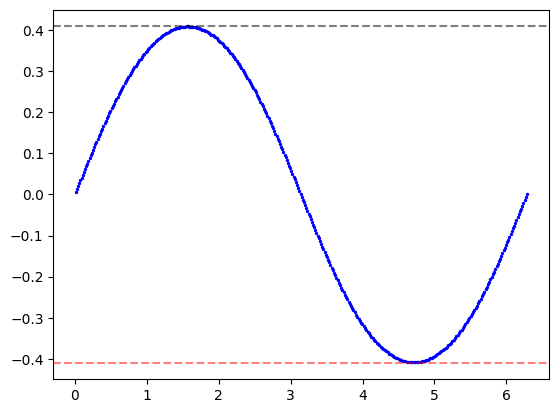

In [119]:
sun_positions = np.zeros((2, 365), dtype='object')
for day in range(365):
    time_elapsed = Time(TIME+day, format='mjd')
    sun = get_sun(time_elapsed)
    sun_positions[0][day] = np.radians(sun.ra.value)
    sun_positions[1][day] = np.radians(sun.dec.value)
    
plt.scatter(sun_positions[0], sun_positions[1], s=2, color='blue')
plt.axhline(y=np.radians(23.5), ls='--', alpha=.5, color="black") # expected peak
plt.axhline(y=np.radians(-23.5), ls='--', alpha=.5, color="red") # expected trough

plt.show()

In [120]:
def dist_angle(dec1:float, ra1:float, dec2:float, ra2:float):
    """Returns the distance (in radians) between two points on the celestial sphere.

    Args:
        dec1 (float): Declination of first point (in radians).
        ra1 (float): Right ascention of first point (in radians).
        dec2 (float): Declination of second point (in radians).
        ra2 (float): Right ascention of second point (in radians).

    Returns:
        float: Distance between two given points on the celestial sphere, in radians.
    """
    return arccos( sin(dec1)*sin(dec2) + cos(dec1)*cos(dec2)*cos(ra2-ra1) ) 

In [121]:
MIN_ANGLE_TOWARDS_SUN = 70 # in degrees
MIN_ANGLE_AWAY_SUN = 60 # in degrees
SLEWRATE = np.radians(4.5) # radians per minute

current_time = Time.now() # current time as GCRS object

current_ra = 0 # in degrees
current_dec = 0 # in degree

def find_visible_targets(time:Time=current_time, targets:pd.DataFrame=targets, sun_angle:float=MIN_ANGLE_TOWARDS_SUN, opp_sun_angle:float=MIN_ANGLE_AWAY_SUN):
    """Returns a data frame of all the targets that are visible at a given time. 

    Args:
        time (Time, optional): given time, as Time object. Defaults to current_time.
        targets (pd.DataFrame, optional): Data frame containing the targets. Defaults to targets.
        sun_angle (float, optional): Limiting angle towards Sun, in degrees. Defaults to MIN_ANGLE_TOWARDS_SUN.
        opp_sun_angle (float, optional): Limiting angle away from Sun, in degrees. Defaults to MIN_ANGLE_AWAY_SUN.

    Returns:
        pd.DataFrame: Data frame containing all the targets visible at a given time. 
    """
    # initializing the list of visible targets and the Sun's coordinates at the given time
    viewable_targets = []
    sunRA = np.radians(get_sun(time).ra.value) # Sun's right ascension, in radians
    sunDEC = np.radians(get_sun(time).dec.value) # Sun's declination, in radians
    
    # iterating through the targets data frame. _ just means that the index will not be used in the loop
    for _, target in targets.iterrows():
        distance = dist_angle(np.radians(target['Star Dec']), np.radians(target['Star RA']), sunDEC, sunRA)
        if distance >= np.radians(sun_angle) and distance <= pi - np.radians(opp_sun_angle): # checks if a target is visible at the given time
            viewable_targets.append(target) # adding target to list since it is visible at the given time
    return pd.DataFrame(viewable_targets)

def find_closest_target(targets:pd.DataFrame=find_visible_targets(), currentRA:float=current_ra, currentDEC:float=current_dec):
    """Returns a data frame containing the nearest target.

    Args:
        targets (pd.DataFrame, optional): d. Defaults to visible_planets().
        currentRA (float, optional): _description_. Defaults to current_ra.
        currentDEC (float, optional): _description_. Defaults to current_dec.

    Returns:
        pd.DataFrame: Data frame containing the target nearest current location
    """
    # initializing necessary variables
    closest_target = None 
    closest_distance = None
    
    # iterating through target data frame. _ just means that the index will not be used in the loop.
    for _, target in targets.iterrows():
        distance = dist_angle(np.radians(currentDEC), np.radians(currentRA), np.radians(target['Star Dec']), np.radians(target['Star RA']))
        if closest_target is None or distance < closest_distance: # checking if the target is closer than the previously closest target.
            closest_target = target
            closest_distance = distance
    return pd.DataFrame(closest_target).transpose()

def find_slewtime_minutes(dec1:float, ra1:float, dec2:float, ra2:float, slewrate:float=SLEWRATE):
    """Returns the slewtime in minutes given the current position and the final/target position.

    Args:
        dec1 (float): intial declination, in radians.
        ra1 (float): initial right ascension, in radians.
        dec2 (float): target declination, in radians.
        ra2 (float): target right ascension, in radians.
        slewrate (float, optional): telescope slew rate. Defaults to SLEWRATE.

    Returns:
        float: slew time, in minutes.
    """
    distance = dist_angle(dec1, ra1, dec2, ra2)
    return (distance / slewrate)

closest = find_closest_target()
closest

,Star Name,Star RA,Star Dec,Planet Period [days],Transit Duration [s]
2741,5852.01,306.528142,1.775949,3.995679,7401.6


In [122]:
SETTLE_TIME = 5 # minutes
DURATION = 0.5 *365*24*60 # minutes
AVERAGE_EVENT_DURATION = 10 *60 # minutes

# Calibration constraints
SHORT_CALIBRATION_DURATION = 1 *60 # minutes
SHORT_CALIBRATION_FREQUENCY = 36 *60 # minutes
LONG_CALIBRATION_DURATION = 6 *60 # minutes
LONG_CALIBRATION_FREQUENCY = 30 *24*60 # minutes



initial_MJD_time = 60209.46657 # some chosen start time in modified julian date format (MJD)

time_since_short_calib = 0
time_since_long_calib = 0
time_elapsed = 0.
observed_events = 0
targets_observed = []
list_targets = targets.copy(deep=True)

# converting duration from years to minutes then cycling through 1 year of operation
while time_elapsed < DURATION:
    
    # finding currently visible targets
    currently_visible = find_visible_targets(Time(initial_MJD_time + time_elapsed/(60*24), format='mjd'),
                                             list_targets
                                             )
    
    closest_target = find_closest_target(currently_visible, current_ra, current_dec) # finds closest target
    list_targets = list_targets.drop(closest_target.index) # drops target that has been observed
    
    targets_observed.append(closest_target['Star Name'].iloc[0]) # adds target to the list of observed targets
    
    target_dec, target_ra = closest_target['Star Dec'].iloc[0], closest_target['Star RA'].iloc[0]
    slewtime = find_slewtime_minutes(np.radians(current_dec), 
                                     np.radians(current_ra), 
                                     np.radians(target_dec), 
                                     np.radians(target_ra))
    
    # updates current position
    current_dec, current_ra = target_dec, target_ra 
    
    # increases time by slewtime and average event duration
    time_elapsed += slewtime + SETTLE_TIME
    time_elapsed += AVERAGE_EVENT_DURATION
    
    # calibration checks
    if time_since_long_calib > LONG_CALIBRATION_FREQUENCY:
        time_elapsed += LONG_CALIBRATION_DURATION
        time_since_long_calib = 0
        if time_since_long_calib > SHORT_CALIBRATION_FREQUENCY:
            time_since_short_calib = 0 # skips short calibration if long one overlaps. 
            
    elif time_since_short_calib > SHORT_CALIBRATION_FREQUENCY:
        time_elapsed += SHORT_CALIBRATION_DURATION
        time_since_short_calib = 0
    
    # increase number of observed events
    observed_events += 1

/var/folders/j_/dlc5r2356bg4ck9zzn93q9vw0000gn/T/ipykernel_69511/998663502.py:13: RuntimeWarning: invalid value encountered in arccos
  return arccos( sin(dec1)*sin(dec2) + cos(dec1)*cos(dec2)*cos(ra2-ra1) )


In [123]:
observed_events

435

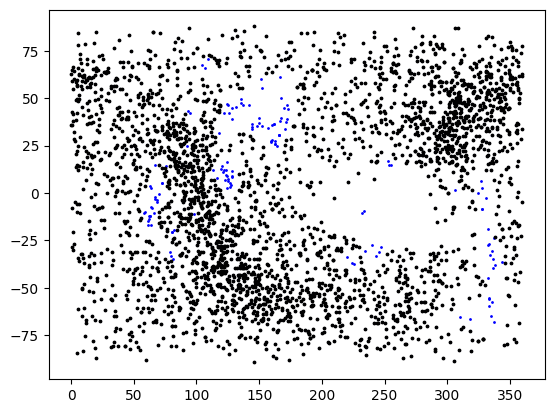

In [132]:
targets_observed_df = []
for target in targets.iloc:
    if target['Star Name'] in targets_observed:
        targets_observed_df.append(target)
targets_observed_df = pd.DataFrame(targets_observed_df)

plt.scatter(targets['Star RA'], targets['Star Dec'], s=1, color='blue')
plt.scatter(targets_observed_df['Star RA'], targets_observed_df['Star Dec'], s=3, color='black')

plt.show()

1.0000000000000022

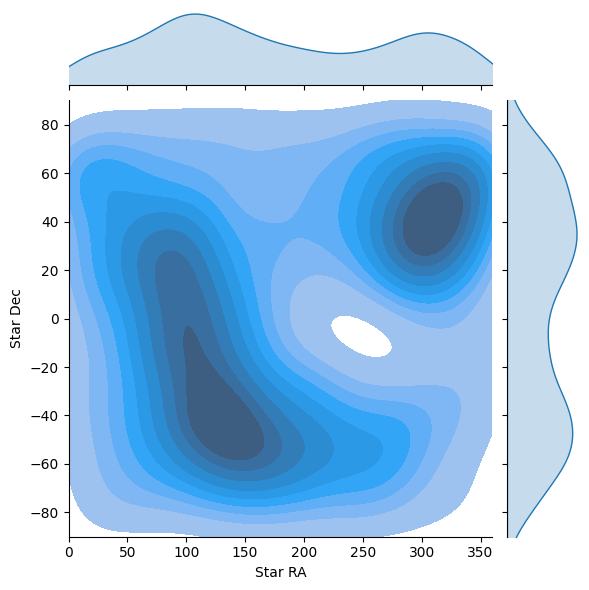

In [ ]:
# Quick plot to see where all targets are in the sky

# plt.scatter(targets['Star RA'], targets['Star Dec'], s=2) # scatter plot
sns.jointplot(x='Star RA', y='Star Dec', data=targets, kind="kde", fill=True, ylim=(-90, 90), xlim=(0,360)) # density plot

plt.show()

In [109]:
# Quick plot to see where the visible targets are at an aforementionned time.

target_list = find_visible_targets()
target_list

# plt.scatter(target_list['Star RA'], target_list['Star Dec'], s=2) # scatter plot
sns.jointplot(x='Star RA', y='Star Dec', data=target_list, kind="kde", fill=True, ylim=(-90, 90), xlim=(0,360)) # density plot

plt.show()

NameError: name 'find_visible_targets' is not defined

0.8535533905932737